# gAIden - Jogando Ninja Gaiden via Deep Q-Learning

## 0 - Criando nosso ambiente

In [1]:
#Importamos todas as bibliotecas que utilizaremos:
import tensorflow as tf  
import numpy as np
import retro
from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames
import matplotlib.pyplot as plt # Display graphs
from collections import deque# Ordered collection with ends
from numpy import random
import warnings 

In [2]:
#Criamos nosso ambiente:
env = retro.make(game='NinjaGaiden-Nes') 

In [3]:
#Estudamos os tamanhos de nossos frames e ações:
print('O tamanho de cada frame é:', env.observation_space)
print('Nosso espaço de ações tem tamanho :', env.action_space.n)

#Fazemos um one-hot-encoding para nossas ações:
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

O tamanho de cada frame é: Box(224, 240, 3)
Nosso espaço de ações tem tamanho : 9


## 1 - Processamento de frames

In [4]:
#Definimos a função de pré-processamento de frames:

def preprocess(frame):
    preto_e_branco=rgb2gray(frame)    #converte o frame em preto e branco
    corte=preto_e_branco[45:-12,6:-12] #corta pedaços da tela que não estamos usando
    norm=corte/255                    #normaliza o frame
    frame_processado=transform.resize(norm,[110,84]) 
    
    
    return frame_processado

preprocess(env.reset()).shape

(110, 84)

Antes de processarmos nossa imagem, ela era:

AxesImage(54,36;334.8x217.44)


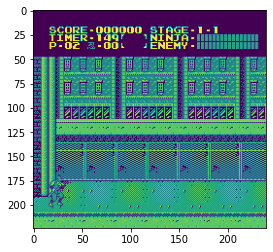

In [5]:
from matplotlib.pyplot import imshow
print(imshow(rgb2gray(env.reset())))

Depois do pré-processamento, ela se torna:

AxesImage(54,36;334.8x217.44)


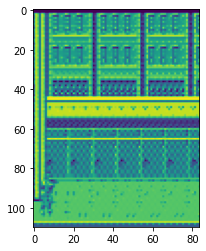

In [6]:
print(imshow(preprocess(env.reset())))

## 2 - Seleção de Hiperparâmetros

In [7]:
#Hiperparâmetros que poderemos ou não variar para avaliar a performance do nosso modelo
state_size = [110, 84,1]      
action_size = env.action_space.n
learning_rate =  0.00025      
total_episodes = 50            
max_steps = 50000              
batch_size = 64                
explore_start = 1.0            
explore_stop = 0.01             
decay_rate = 0.00001           
gamma = 0.9                    
pretrain_length = batch_size   
memory_size = 2000                          

## 3 - Desenvolvendo nossa Rede Neural

Em termos de arquitetura, nossa rede neural será composta da seguinte maneira:

In [8]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam 


#Primeiro vamos criar nosso Replay:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size=max_size
        self.mem_cntr=0
        self.discrete=discrete
        self.state_memory=np.zeros((self.mem_size,input_shape), dtype=np.float32)
        self.new_state_memory=np.zeros((self.mem_size,input_shape), dtype=np.float32)
        dtype=np.int8 if self.discrete else np.float32
        self.action_memory=np.zeros((self.mem_size,n_actions), dtype=dtype)
        self.reward_memory=np.zeros(self.mem_size)
        self.terminal_memory=np.zeros(self.mem_size, dtype=np.float32)
        
    def store_transition(self, state, action, reward, state_, done):
        index=self.mem_cntr % self.mem_size
        #self.state_memory[index]=np.reshape(state,9240)
        self.state_memory[index]=np.reshape(state,9240)
        self.new_state_memory[index]=np.reshape(state_,9240)
        self.reward_memory[index]=reward
        self.terminal_memory[index]=1-int(done)
        if self.discrete:
            actions=np.zeros(self.action_memory.shape[1])
            actions[action]=1.0
            self.action_memory[index]=actions
        else:
            self.action_memory[index]=action
        self.mem_cntr+=1
    
    def sample_buffer(self, batch_size):
        max_mem=min(self.mem_cntr, self.mem_size)
        batch=np.random.choice(max_mem, batch_size, replace=False)
        
        states=self.state_memory[batch]
        states_=self.new_state_memory[batch]
        rewards=self.reward_memory[batch]
        actions=self.action_memory[batch]
        terminal=self.terminal_memory[batch]
        
        return states, actions, rewards, states_, terminal
    
    
#Determinamos nosso modelo:
model = keras.Sequential(
    [keras.Input(shape=(batch_size,110,84)),
     Conv2D(filters = 32, kernel_size = [8,8], strides = [4,4], 
                        padding='valid',kernel_initializer="glorot_uniform"),
     Conv2D(filters = 64, kernel_size = [4,4], strides = [2,2], 
                        padding='valid',kernel_initializer="glorot_uniform"),
     Conv2D(filters = 64, kernel_size = [3,3], strides = [2,2], 
                        padding='valid',kernel_initializer="glorot_uniform"),
     Flatten(),
     Dense(action_size, activation='linear')
     ]
)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
        

#Agora criamos nosso agente
class DQNAgent():
    def __init__(self, env):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.action_space=[i for i in range(action_size)]
        self.episodes = total_episodes
        self.env._max_episode_steps = max_steps
        self.epsilon = explore_start
        self.epsilon_decay = decay_rate
        self.epsilon_min = explore_stop
        self.gamma = gamma
        self.alpha = learning_rate
        self.batch_size = batch_size
        self.model = model
        self.memory=ReplayBuffer(memory_size, 9240 ,action_size, discrete=True)
        self.q_eval= model
        
        
    def act(self, state):
        if (np.random.random() <= self.epsilon):
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.store_transition(state, action, reward, next_state, done)
        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, next_state, done = self.memory.sample_buffer(batch_size)
        
        action_values=np.array(self.action_space, dtype=np.int8)
        action_indices=np.dot(action, action_values)
        
        
        q_eval=self.q_eval.predict(state)
        q_next=self.q_eval.predict(next_state)
        q_target=q_eval.copy()
        
        batch_index=np.arange(self.batch_size, dtype=np.int32)
        
        q_target[batch_index, action_indices]=reward+self.gamma*np.max(q_next,axis=1)*done
        _=self.q_eval.fit(state, q_target, verbose=0)
        
        self.epsilon=self.epsilon*self.epsilon_decay if self.epsilon>self.epsilon_min  else self.epsilon_min
        
        
    def save_model(self):
        self.q_eval.save(self.model)
        
    def load_model(self):
        self.q_eval.load(self.model)
           
    


Using TensorFlow backend.


In [ ]:
#Treinando e vendo nosso agente evoluir.
dqn_agent = DQNAgent(env=env)
steps = []

done=False
state=env.reset()
i=0

for i in range(0,total_episodes):
    print('geração {}'.format(i))
    state=env.reset()
    done=False
    while not done:
        state=preprocess(state)
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state=preprocess(next_state)
        #dqn_agent.remember(state, action, reward, next_state, done)
        dqn_agent.learn()
        state=next_state
        env.render()

geração 0


C:\Users\renat\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] Não é possível alterar o modo de thread depois de o mesmo estar definido
  warnings.warn(str(err))


geração 1
geração 2
geração 3
geração 4
geração 5
geração 6
